In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
plt.style.use('ggplot')

In [2]:
# Read in the dataframes
train_df = pd.read_parquet('../input/train_df.parquet.gzip')
test_df = pd.read_parquet('../input/test_df.parquet.gzip')
merch_df = pd.read_parquet('../input/merch_df.parquet.gzip')
hist_trans_df = pd.read_parquet('../input/hist_trans_df.parquet.gzip')
new_trans_df = pd.read_parquet('../input/new_trans_df.parquet.gzip')
ss_df = pd.read_parquet('../input/ss_df.parquet.gzip')

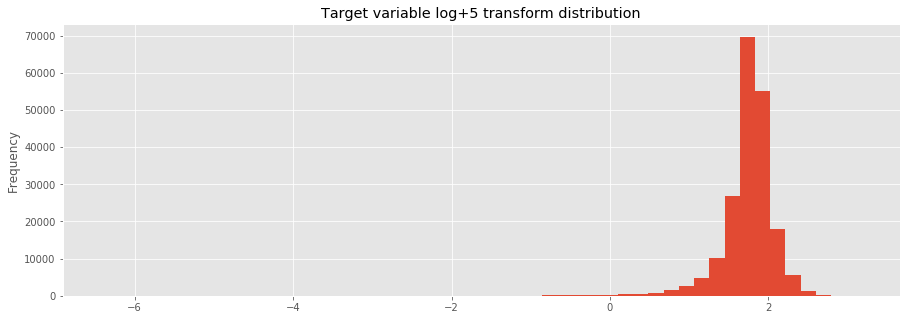

In [3]:
train_df['target_log5p'] = (train_df['target'] + 5).apply(np.log1p)
train_df['target_log5p'].plot(kind='hist',
                              bins=50,
                              figsize=(15, 5),
                              title='Target variable log+5 transform distribution')
plt.show()

In [4]:
# Create features from historic transactions
hist_agg_df = hist_trans_df.groupby('card_id')['purchase_amount']\
    .agg(['count', 'sum', 'mean', 'std', 'min', 'max']).reset_index()
hist_agg_df.columns = ['card_id', 'hist_trans_num', 'hist_trans_sum',
                       'hist_trans_mean', 'hist_trans_std',
                       'hist_trans_min', 'hist_trans_max']
hist_agg_df.head(5)

,card_id,hist_trans_num,hist_trans_sum,hist_trans_mean,hist_trans_std,hist_trans_min,hist_trans_max
0,C_ID_00007093c1,149,-76.845041,-0.515739,0.298141,-0.728876,1.507069
1,C_ID_0001238066,123,-72.447201,-0.589002,0.190235,-0.734887,0.768095
2,C_ID_0001506ef0,66,-34.601879,-0.524271,0.472284,-0.740491,1.493545
3,C_ID_0001793786,216,-36.786013,-0.170306,0.836046,-0.745405,4.554145
4,C_ID_000183fdda,144,-68.837938,-0.478041,0.524948,-0.737892,2.764788


In [5]:
# Create features from new transactions
new_agg_df = new_trans_df.groupby('card_id')['purchase_amount']\
    .agg(['count', 'sum', 'mean', 'std', 'min', 'max']).reset_index()
new_agg_df.columns = ['card_id', 'new_trans_num', 'new_trans_sum',
                      'new_trans_mean', 'new_trans_std',
                      'new_trans_min', 'new_trans_max']
new_agg_df.head(5)

,card_id,new_trans_num,new_trans_sum,new_trans_mean,new_trans_std,new_trans_min,new_trans_max
0,C_ID_00007093c1,2,-1.328524,-0.664262,0.010625,-0.671775,-0.656749
1,C_ID_0001238066,26,-14.850055,-0.571156,0.173436,-0.740897,-0.078318
2,C_ID_0001506ef0,2,-1.447354,-0.723677,0.011773,-0.732001,-0.715352
3,C_ID_0001793786,31,-0.229620,-0.007407,0.947223,-0.737892,3.129932
4,C_ID_000183fdda,11,-6.590778,-0.599162,0.182877,-0.732332,-0.107680


In [6]:
def merge_transactions(df, trans_agg_df):
    """Merges the historic and new transactions data with train or test set"""
    df = pd.merge(df, trans_agg_df, on="card_id", how="left")
    return df

In [7]:
train_df = merge_transactions(train_df, hist_agg_df)
train_df = merge_transactions(train_df, new_agg_df)
train_df.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_log5p,hist_trans_num,hist_trans_sum,hist_trans_mean,hist_trans_std,hist_trans_min,hist_trans_max,new_trans_num,new_trans_sum,new_trans_mean,new_trans_std,new_trans_min,new_trans_max
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,1.644750,260,-165.968739,-0.638341,0.212139,-0.739395,2.258395,23.0,-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1.855190,350,-210.006336,-0.600018,0.384967,-0.742400,4.630299,6.0,-4.355735,-0.725956,0.014326,-0.739410,-0.701858
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,1.900323,43,-29.167391,-0.678311,0.087380,-0.730138,-0.145847,1.0,-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.815231,77,-49.491364,-0.642745,0.261624,-0.740897,1.445596,7.0,-4.654372,-0.664910,0.065882,-0.734135,-0.566740
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,1.764774,133,-48.687656,-0.366073,1.352094,-0.746156,7.193041,36.0,-19.926237,-0.553507,0.223821,-0.739395,0.450886


In [8]:
test_df = merge_transactions(test_df, hist_agg_df)
test_df = merge_transactions(test_df, new_agg_df)
test_df.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_trans_num,hist_trans_sum,hist_trans_mean,hist_trans_std,hist_trans_min,hist_trans_max,new_trans_num,new_trans_sum,new_trans_mean,new_trans_std,new_trans_min,new_trans_max
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,68,-40.733733,-0.599025,0.192268,-0.743902,0.235676,3.0,-1.777156,-0.592385,0.182843,-0.722114,-0.383266
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,78,-49.136513,-0.629955,0.154999,-0.731881,0.318817,9.0,-5.944698,-0.660522,0.071147,-0.740897,-0.506484
2,2017-08-01,C_ID_b709037bc5,5,1,1,13,4.528840,0.348372,0.906547,-0.536537,2.525866,2.0,0.180138,0.090069,1.151788,-0.724368,0.904506
3,2017-12-01,C_ID_d27d835a9f,2,1,0,26,-13.690715,-0.526566,0.219162,-0.731881,0.087965,10.0,-5.743674,-0.574367,0.073166,-0.671775,-0.447880
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,110,25.139384,0.228540,2.777764,-0.746758,15.782255,6.0,12.064997,2.010833,6.028671,-0.704082,14.279604


In [9]:
# Fill the NA value with the last month
test_df['first_active_month'] = test_df['first_active_month'].fillna(pd.Timestamp('2018-01-01'))

In [10]:
def create_features(df, target=False):
    """
    Creates raw features including one hot encoding for train and test
    """
    # One-hot encode features
    feature_1_df = pd.get_dummies(df['feature_1'], prefix='f1_')
    feature_2_df = pd.get_dummies(df['feature_2'], prefix='f2_')
    feature_3_df = pd.get_dummies(df['feature_3'], prefix='f3_')
    # Numerical representation of the first active month
    fam_num_df = pd.to_timedelta(df['first_active_month']).dt.total_seconds().astype(int)
    # Historical and new transcation features
    trans_features_df = df[['hist_trans_num', 'hist_trans_sum',
                            'hist_trans_mean', 'hist_trans_std',
                            'hist_trans_min', 'hist_trans_max',
                            'new_trans_num', 'new_trans_sum',
                            'new_trans_mean', 'new_trans_std',
                            'new_trans_min', 'new_trans_max']]
    if target:
        return pd.concat([feature_1_df, feature_2_df, feature_3_df, fam_num_df, trans_features_df], axis=1, sort=False), df['target']
    return pd.concat([feature_1_df, feature_2_df, feature_3_df, fam_num_df, trans_features_df], axis=1, sort=False)

In [11]:
# preparing training and testing data set
X_train_df, y_train_df = create_features(train_df, target=True)
X_test_df = create_features(test_df, target=False)

In [12]:
# split the train data set into train and validation
X_train_tr_df, X_train_val_df, y_train_tr_df, y_train_val_df = train_test_split(X_train_df,
                                                                                y_train_df,
                                                                                test_size=0.8,
                                                                                random_state=123)

In [13]:
trn_data = lgb.Dataset(X_train_tr_df.values, label=y_train_tr_df.values)
val_data = lgb.Dataset(X_train_val_df.values, label=y_train_val_df.values)
params = {'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 30,
          'min_child_weight': 50,
          'learning_rate': 0.05,
          'bagging_fraction': 0.7,
          'feature_fraction': 0.7,
          'bagging_frequency': 5,
          'bagging_seed': 2018,
          'verbosity': -1}
cv_results = lgb.cv(params=params,
                    train_set=trn_data,
                    num_boost_round=500,
                    nfold=5,
                    stratified=False,
                    early_stopping_rounds=50,
                    verbose_eval=10,
                    seed=123)
print(cv_results['rmse-mean'][-1], len(cv_results['rmse-mean']))

[10]	cv_agg's rmse: 3.81698 + 0.159788
[20]	cv_agg's rmse: 3.8078 + 0.160013
[30]	cv_agg's rmse: 3.80421 + 0.159786
[40]	cv_agg's rmse: 3.80202 + 0.159888
[50]	cv_agg's rmse: 3.8016 + 0.159587
[60]	cv_agg's rmse: 3.80087 + 0.159163
[70]	cv_agg's rmse: 3.80117 + 0.159663
[80]	cv_agg's rmse: 3.80222 + 0.159282
[90]	cv_agg's rmse: 3.80333 + 0.159816
[100]	cv_agg's rmse: 3.80408 + 0.159589
[110]	cv_agg's rmse: 3.80489 + 0.15973
3.8006865949584183 61


In [14]:
valid_sets = [trn_data, val_data]
evals_result = {}
model = lgb.train(params=params,
                  train_set=trn_data,
                  num_boost_round=len(cv_results['rmse-mean']),
                  valid_sets=valid_sets,
                  evals_result=evals_result,
                  verbose_eval=10)

[10]	training's rmse: 3.80058	valid_1's rmse: 3.831
[20]	training's rmse: 3.77411	valid_1's rmse: 3.82192
[30]	training's rmse: 3.75269	valid_1's rmse: 3.8179
[40]	training's rmse: 3.73595	valid_1's rmse: 3.81582
[50]	training's rmse: 3.72034	valid_1's rmse: 3.81472
[60]	training's rmse: 3.7055	valid_1's rmse: 3.8142


In [15]:
print('Number of boosting rounds {0}, Training RMSE: {1}, Testing RMSE: {2}'.format(len(evals_result['training']['rmse']),
                                                                                    evals_result['training']['rmse'][-1],
                                                                                    evals_result['valid_1']['rmse'][-1]))

Number of boosting rounds 61, Training RMSE: 3.7042890439475693, Testing RMSE: 3.81420001073156


In [16]:
# Predict and format submission
preds = model.predict(X_test_df.values, num_iteration=model.best_iteration)
submission_df = pd.concat([test_df['card_id'], pd.Series(preds)], axis = 1)
submission_df = submission_df.rename(columns={0: 'target'})
print('submission shape', submission_df.shape)

submission shape (123623, 2)


In [17]:
# show submission data
submission_df.head(5)

,card_id,target
0,C_ID_0ab67a22ab,-0.690576
1,C_ID_130fd0cbdd,-0.853438
2,C_ID_b709037bc5,-0.748835
3,C_ID_d27d835a9f,-0.236994
4,C_ID_2b5e3df5c2,-1.763330


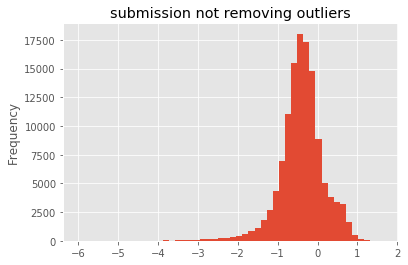

In [18]:
# plot submission distribution
submission_df['target'].plot(kind='hist', bins=50, title='submission not removing outliers')
plt.show()